# **Business Case Porter: Neural Network Regression**

### **About Business:**
*Porter is India's Largest Marketplace for Intra-City Logistics. Leader in the country's $40 billion intra-city logistics market, Porter strives to improve the lives of 1,50,000+ driver-partners by providing them with consistent earning & independence. Currently, the company has serviced 5+ million customers.*

*Porter works with a wide range of restaurants for delivering their items directly to the people.*

*Porter has a number of delivery partners available for delivering the food, from various restaurants and wants to get an estimated delivery time that it can provide the customers on the basis of what they are ordering, from where and also the delivery partners.*

### **Problem Statement:**
*Porter has a requirement to train a regression model that will do the delivery time estimation, based on the data collected over a course of time.*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import tensorflow
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from livelossplot import PlotLossesKeras

# For reproducibility
np.random.seed(42)
tensorflow.random.set_seed(42)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/porter.csv')
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0


### **About the Dataset (Column Profiling):**

Each row in this file corresponds to one unique delivery. Each column corresponds to a feature as explained below.

1. **market_id** : *integer id for the market where the restaurant lies.*
2. **created_at** : *the timestamp at which the order was placed.*
3. **actual_delivery_time** : *the timestamp when the order was delivered.*
4. **store_primary_category** : *category for the restaurant.*
5. **order_protocol** : *integer code value for order protocol(how the order was placed ie: through porter, call to restaurant, pre booked, third part etc).*
6. **total_items subtotal** : *final price of the order.*
7. **num_distinct_items** : *the number of distinct items in the order.*
8. **min_item_price** : *price of the cheapest item in the order.*
9. **max_item_price** : *price of the costliest item in order.*
10. **total_onshift_partners** : *number of delivery partners on duty at the time order was placed.*
11. **total_busy_partners** : *number of delivery partners attending to other tasks.*
12. **total_outstanding_orders** : *total number of orders to be fulfilled at the moment.*

Checking the structure of the data and datatypes in the data.

In [ ]:
print('No. of rows in the data:', df.shape[0])
print('No. of columns in the data:', df.shape[1])

No. of rows in the data: 197428
No. of columns in the data: 14


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   created_at                197428 non-null  object 
 2   actual_delivery_time      197421 non-null  object 
 3   store_id                  197428 non-null  object 
 4   store_primary_category    192668 non-null  object 
 5   order_protocol            196433 non-null  float64
 6   total_items               197428 non-null  int64  
 7   subtotal                  197428 non-null  int64  
 8   num_distinct_items        197428 non-null  int64  
 9   min_item_price            197428 non-null  int64  
 10  max_item_price            197428 non-null  int64  
 11  total_onshift_partners    181166 non-null  float64
 12  total_busy_partners       181166 non-null  float64
 13  total_outstanding_orders  181166 non-null  f

Here we can see that there are some null values in the data and the data contains object, int and float datatype. We can also observe from the dataframe that the features **created_at** and **actual_delivery_time** are represented as object datatype but it should be datetime datatype as those features represent date and time at which the order were created and delivered.

### **Statistical Summary:**

In [ ]:
df.describe()

,market_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
count,196441.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000
mean,2.978706,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065
std,1.524867,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830
min,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000
25%,2.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000
50%,3.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000
75%,4.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000
max,6.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000


In [ ]:
df.describe(include='O')

,created_at,actual_delivery_time,store_id,store_primary_category
count,197428,197421,197428,192668
unique,180985,178110,6743,74
top,2015-02-11 19:50:43,2015-02-11 20:40:45,d43ab110ab2489d6b9b2caa394bf920f,american
freq,6,5,937,19399


Here the problem statement is to create a regression model to predict delivery time estimation but we can observe from the data that we dont have target variable representing the delivery time. Here we can create the target variable using the features **created_at** and **actual_delivery_time** but first we will have to convert the features to datetime from object datatype.

In [ ]:
# converting the required features from object to pandas datetime
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

In [ ]:
# Creating the target variable
df['delivery_time_in_mins'] = df['actual_delivery_time'] - df['created_at']

In [ ]:
df['delivery_time_in_mins'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 197428 entries, 0 to 197427
Series name: delivery_time_in_mins
Non-Null Count   Dtype          
--------------   -----          
197421 non-null  timedelta64[ns]
dtypes: timedelta64[ns](1)
memory usage: 1.5 MB


### **Creating Target Feature:**
Here we can see that our target feature is in timedelta format, we need to convert it to minutes as our target should be a continuos(float) number for our model to predict.

In [ ]:
df['delivery_time_in_mins'] = df['delivery_time_in_mins'] / pd.Timedelta('60s')

We will be extracting the hour of the day and day of the week from **created_at** feature, this will help us generate insights on hour to hour and day to day basis.

In [ ]:
df['hour_of_day'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.dayofweek

In [ ]:
# Dropping "created_at" and "actual_delivery_time" features as we have already extracted trhe required information from these features.
df = df.drop(columns=['created_at', 'actual_delivery_time'])

In [ ]:
df.describe()

,market_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time_in_mins,hour_of_day,day_of_week
count,196441.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197421.000000,197428.000000,197428.000000
mean,2.978706,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,48.470956,8.467213,3.218966
std,1.524867,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,320.493482,8.658759,2.045789
min,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,1.683333,0.000000,0.000000
25%,2.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,35.066667,2.000000,1.000000
50%,3.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,44.333333,3.000000,3.000000
75%,4.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,56.350000,19.000000,5.000000
max,6.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,141947.650000,23.000000,6.000000


In [ ]:
df.describe(include='O')

,store_id,store_primary_category
count,197428,192668
unique,6743,74
top,d43ab110ab2489d6b9b2caa394bf920f,american
freq,937,19399


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   store_id                  197428 non-null  object 
 2   store_primary_category    192668 non-null  object 
 3   order_protocol            196433 non-null  float64
 4   total_items               197428 non-null  int64  
 5   subtotal                  197428 non-null  int64  
 6   num_distinct_items        197428 non-null  int64  
 7   min_item_price            197428 non-null  int64  
 8   max_item_price            197428 non-null  int64  
 9   total_onshift_partners    181166 non-null  float64
 10  total_busy_partners       181166 non-null  float64
 11  total_outstanding_orders  181166 non-null  float64
 12  delivery_time_in_mins     197421 non-null  float64
 13  hour_of_day               197428 non-null  i

Above in the info of the data we can see we have already dealt with the datatype of the features. Now we will start with the data cleaning and preprocessing task.

**Checking No. of unique values in each of the columns:**

In [ ]:
for col in df.columns:
  print(f'No. of unique values in {col}:', df[col].nunique())

No. of unique values in market_id: 6
No. of unique values in store_id: 6743
No. of unique values in store_primary_category: 74
No. of unique values in order_protocol: 7
No. of unique values in total_items: 57
No. of unique values in subtotal: 8368
No. of unique values in num_distinct_items: 20
No. of unique values in min_item_price: 2312
No. of unique values in max_item_price: 2652
No. of unique values in total_onshift_partners: 172
No. of unique values in total_busy_partners: 159
No. of unique values in total_outstanding_orders: 281
No. of unique values in delivery_time_in_mins: 7134
No. of unique values in hour_of_day: 19
No. of unique values in day_of_week: 7


###**Dealing with Null/Missing values:**

In [ ]:
round(df.isnull().sum() * 100 / df.shape[0], 2)

market_id                   0.50
store_id                    0.00
store_primary_category      2.41
order_protocol              0.50
total_items                 0.00
subtotal                    0.00
num_distinct_items          0.00
min_item_price              0.00
max_item_price              0.00
total_onshift_partners      8.24
total_busy_partners         8.24
total_outstanding_orders    8.24
delivery_time_in_mins       0.00
hour_of_day                 0.00
day_of_week                 0.00
dtype: float64

Above we can see that there are total of 6 columns with Null values. For the columns which have null values less than 3% will remove the rows and for the columns with null values greater than 3% will impute the null values with the required imputations.

In [ ]:
# In feature market_id and order_protocol we can see there are 0.5% null values which can be dropped.
# Also feature delivery_time_in_mins feature has 7 Null values we can also drop these rows
df.dropna(subset=['market_id','order_protocol','delivery_time_in_mins'], inplace=True)

In [ ]:
# Now imputing the Null values in store_primary_category feature with the mode of the entire columns as it is a categorical column.
df['store_primary_category'].fillna(df['store_primary_category'].mode()[0], inplace=True)

In [ ]:
# Now we have to impute the Null values of the features "total_onshift_partners", "total_busy_partners" and "total_outstanding_orders".
# We will do this imputing for the features on market category basis.
df['total_onshift_partners'] = df.groupby('market_id')['total_onshift_partners'].transform(lambda x : x.fillna(x.median()))
df['total_busy_partners'] = df.groupby('market_id')['total_busy_partners'].transform(lambda x : x.fillna(x.median()))
df['total_outstanding_orders'] = df.groupby('market_id')['total_outstanding_orders'].transform(lambda x : x.fillna(x.median()))

In [ ]:
df.isnull().sum()

market_id                   0
store_id                    0
store_primary_category      0
order_protocol              0
total_items                 0
subtotal                    0
num_distinct_items          0
min_item_price              0
max_item_price              0
total_onshift_partners      0
total_busy_partners         0
total_outstanding_orders    0
delivery_time_in_mins       0
hour_of_day                 0
day_of_week                 0
dtype: int64

As we can see above we have dealt with all the Null values present in the data. Also we can drop the **store_id** feature as it is not much relatable to our problem statement.

In [ ]:
df.drop(columns=['store_id'], inplace=True)

### Checking for duplicate rows:

In [ ]:
df.duplicated().sum() # There are no duplicate rows present in the dataset.

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195926 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 195926 non-null  float64
 1   store_primary_category    195926 non-null  object 
 2   order_protocol            195926 non-null  float64
 3   total_items               195926 non-null  int64  
 4   subtotal                  195926 non-null  int64  
 5   num_distinct_items        195926 non-null  int64  
 6   min_item_price            195926 non-null  int64  
 7   max_item_price            195926 non-null  int64  
 8   total_onshift_partners    195926 non-null  float64
 9   total_busy_partners       195926 non-null  float64
 10  total_outstanding_orders  195926 non-null  float64
 11  delivery_time_in_mins     195926 non-null  float64
 12  hour_of_day               195926 non-null  int32  
 13  day_of_week               195926 non-null  int32 

## **Data Visualization and Analysis:**
### Univariate Analysis:

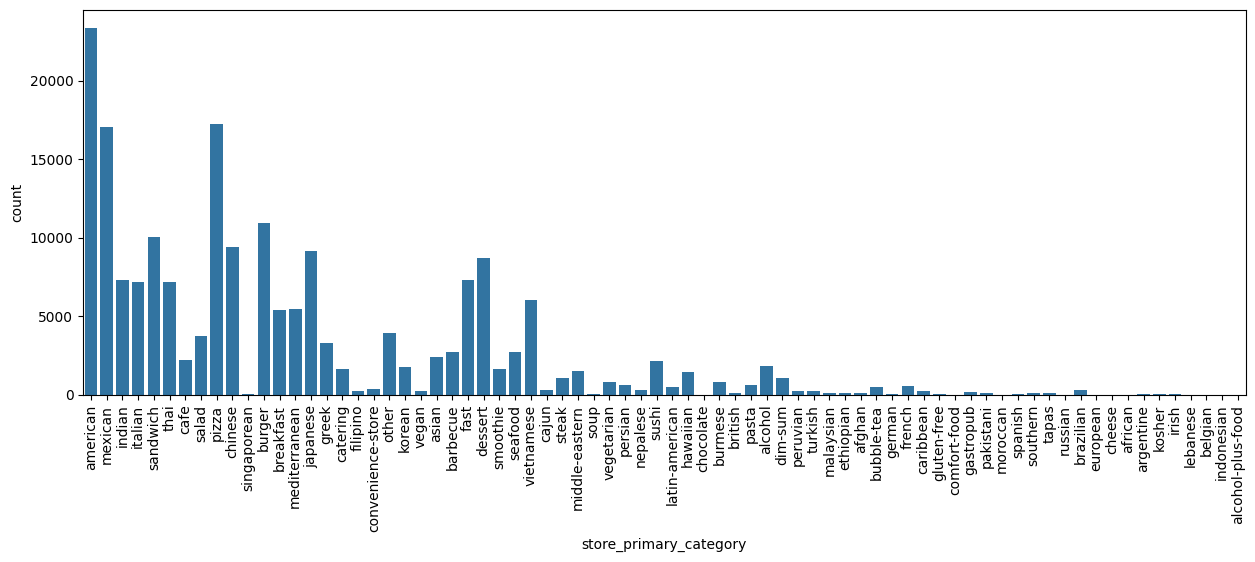

In [ ]:
# Lets do some visualizations on categorical data.
fig, axes = plt.subplots(figsize=(15,5))
sns.countplot(data=df, x='store_primary_category', ax=axes)
plt.xticks(rotation=90)
plt.show()

Here we can see above that the most number of deliveries are from American restaurant followed by Pizzeria on 2nd place and Mexican on 3rd place. This shows that customers like to enjoy the american, pizzeria, mexican, etc. kind of cuisine. There are other cuisines as well but the most sold/delivered are these.

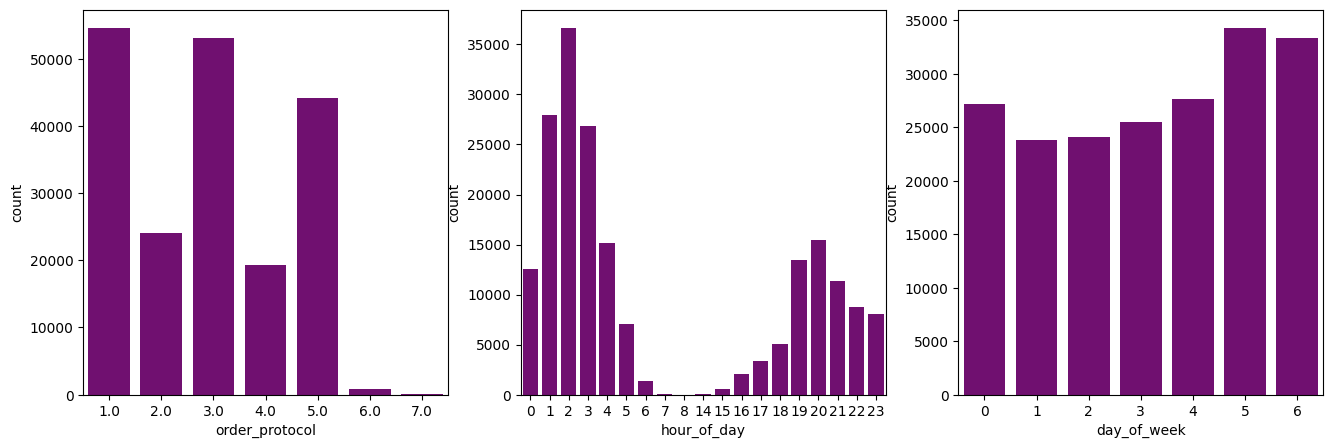

In [ ]:
catcols = ['order_protocol', 'hour_of_day', 'day_of_week']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5))
for i in range(len(catcols)):
  sns.countplot(data=df, x=catcols[i], ax = axes[i], color='purple')
plt.show()

From the above plots we can see that for order protocol 1, 3 and 5 has the highest number of deliveries. Also the number of deliveries tend to be at its peak during 1PM to 3PM in the afternoon and 7PM to 9PM during the night, which is as expected. Also from day of week plot we can observe that the number of deliveries are approximately same for weekdays but are high in number on the weekends i.e on saturday and sunday in our case 5 and 6.

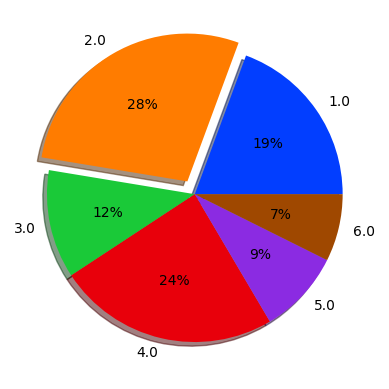

In [ ]:
data = df.groupby('market_id')['market_id'].count().tolist()
palette_color = sns.color_palette('bright')
plt.pie(data, labels=df['market_id'].unique(), colors=palette_color, autopct='%.0f%%', explode=[0,0.1,0,0,0,0], shadow=True)
plt.show()

From the above pie chart we can see that majority of the deliveries are from market 2 and 4 with total combined share of 52%, with market contributing 28% and market 4 contributing 24%. Market 1 also has a fair share of 19%.

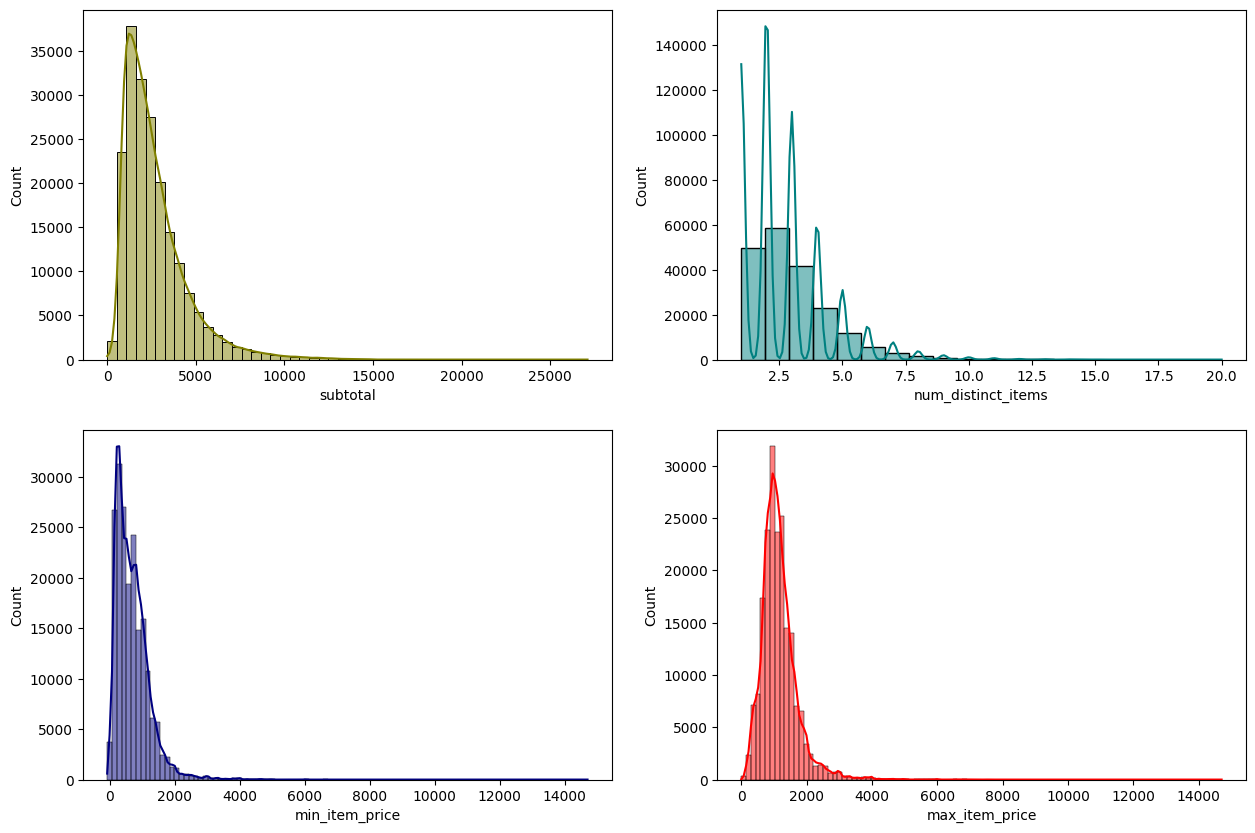

In [ ]:
numcols= ['subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price']
fig, axes = plt.subplots(2,2,figsize=(15,10))
sns.histplot(data=df, x='subtotal', ax=axes[0][0], bins=50, kde=True, color='olive')
sns.histplot(data=df, x='num_distinct_items', ax=axes[0][1], bins=20, kde=True, color='teal')
sns.histplot(data=df, x='min_item_price', ax=axes[1][0], bins=100, kde=True, color='navy')
sns.histplot(data=df, x='max_item_price', ax=axes[1][1], bins=100, kde=True, color='red')
plt.show()

The max number of distinct items present in the deliveries is in between 1 to 3. Orders with subtotal value of 1000 to 4000 are contributing more to the business. Minimum item price in range of 500 to 750 is contributing to most of the orders same goes with maximum item price with range of 1000 to 1300.

### Bivariate Analysis:

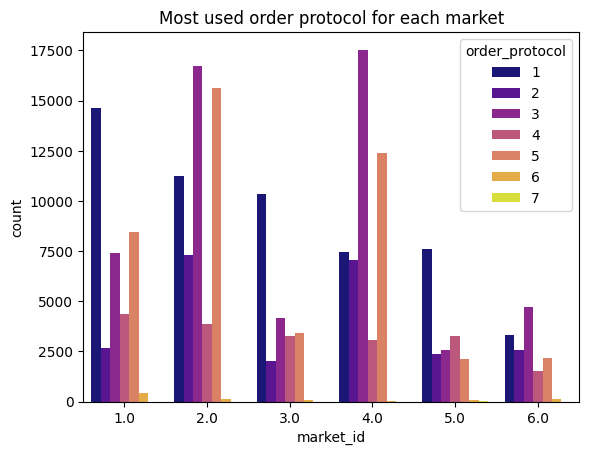

In [ ]:
sns.countplot(data=df, x='market_id', hue='order_protocol', palette='plasma')
plt.title('Most used order protocol for each market')
plt.show()

For market 2 and 4 the most used order protocol to order is protocol 3 and for market 1 and 5 the most used order protocol is 1.

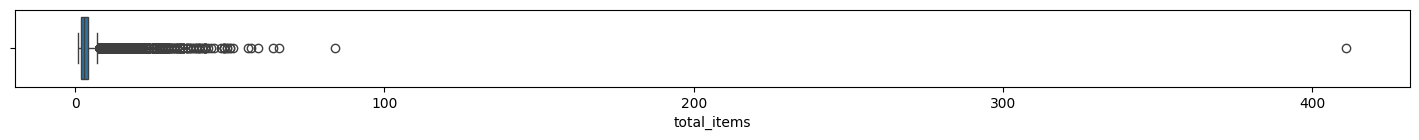

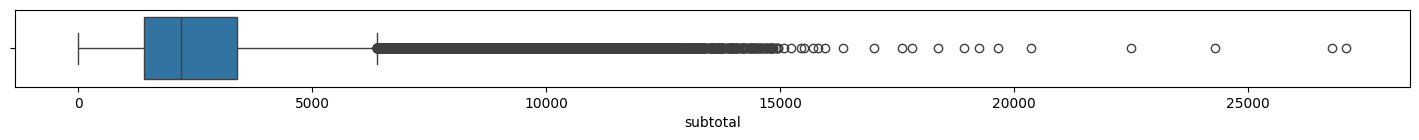

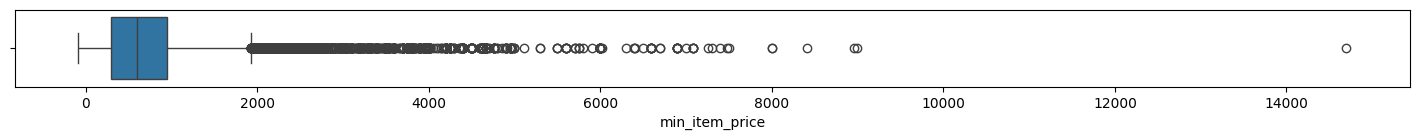

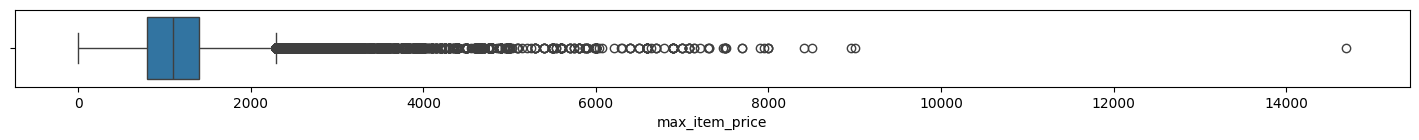

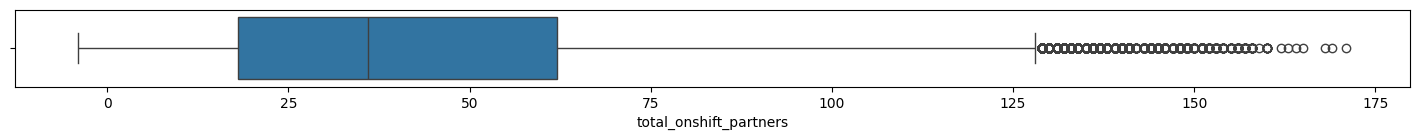

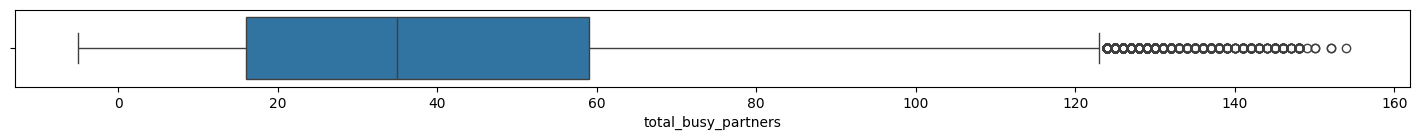

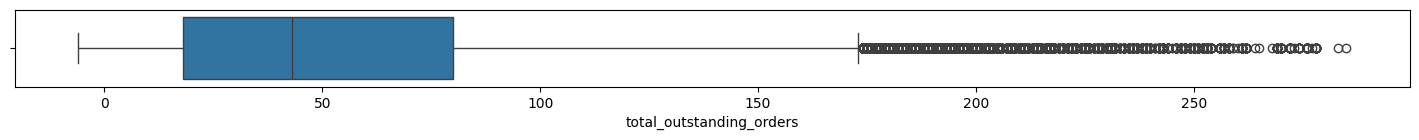

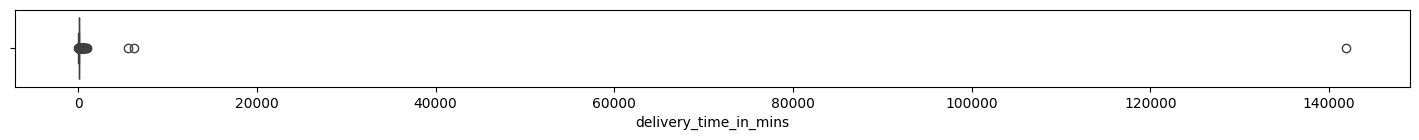

In [ ]:
cols = ['total_items', 'subtotal', 'min_item_price', 'max_item_price', 'total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders', 'delivery_time_in_mins']

for i in range(len(cols)):
  plt.figure(figsize=(18,1))
  sns.boxplot(data=df, x=cols[i])
plt.show()

As we can see from above plots that our data has good number of outliers and removing or clipping of outliers could lead to data loss as our data is heavily skewed towards left. So we can only remove those extreme outliers which can impact our model

### **Outlier Treatment:**

In [ ]:
# Before treating outliers using the LOF method we will have to label encode our categorical feature 'store_primary_category'.
df['store_primary_category'] = df['store_primary_category'].astype('category').cat.codes

In [ ]:
model1=LocalOutlierFactor()
#model1.fit(df)
df['lof_anomaly_score']=model1.fit_predict(df)

In [ ]:
print("number of outliers : ",(len(df.loc[(df['lof_anomaly_score'] == -1)])))
df=df.loc[(df['lof_anomaly_score'] == 1)]

number of outliers :  2248


In [ ]:
df.drop(['lof_anomaly_score'],axis=1,inplace=True)

<ipython-input-35-a629ff9cb1da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['lof_anomaly_score'],axis=1,inplace=True)


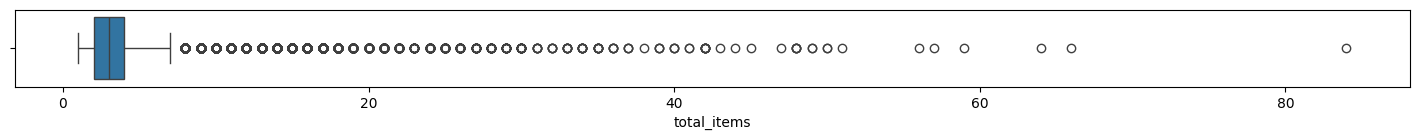

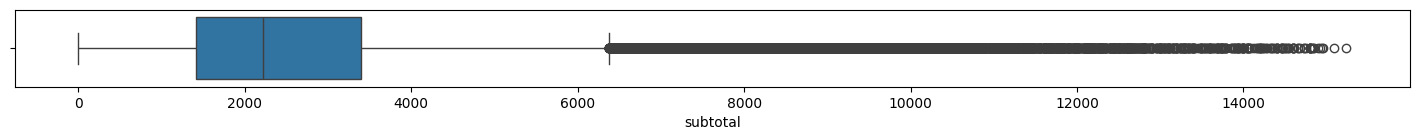

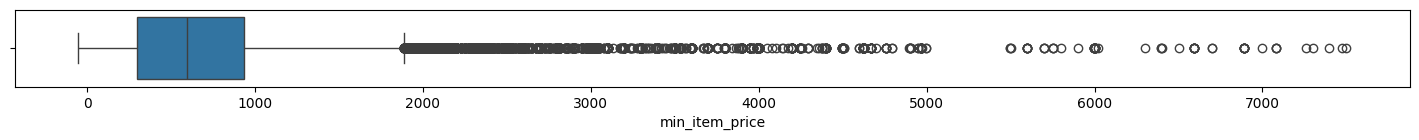

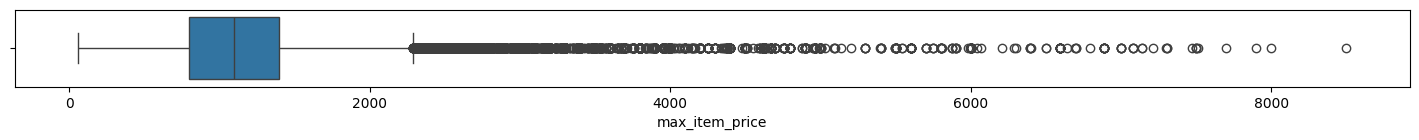

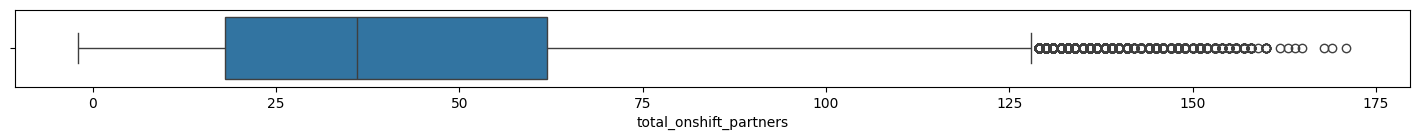

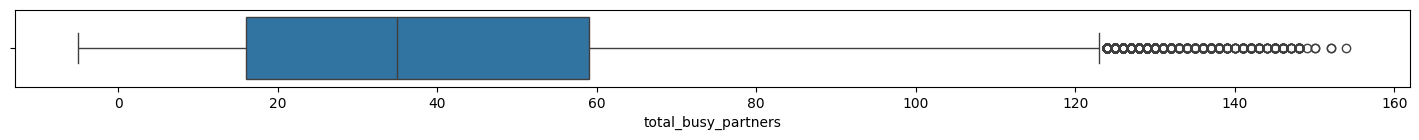

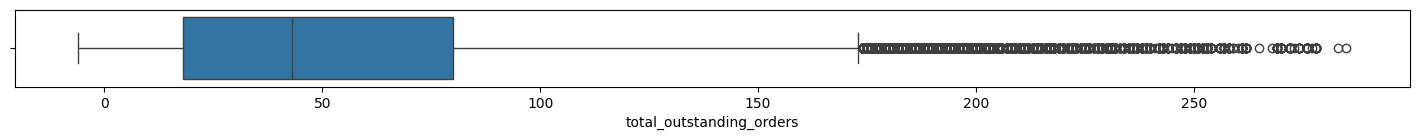

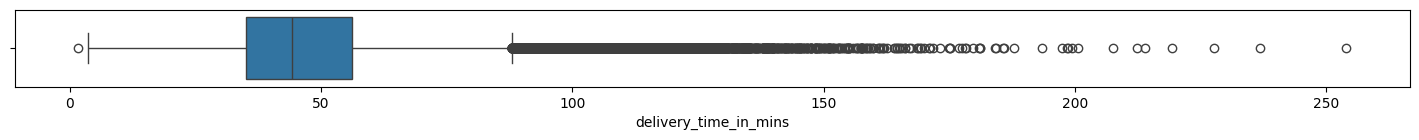

In [ ]:
cols = ['total_items', 'subtotal', 'min_item_price', 'max_item_price', 'total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders', 'delivery_time_in_mins']

for i in range(len(cols)):
  plt.figure(figsize=(18,1))
  sns.boxplot(data=df, x=cols[i])
plt.show()

From the above boxplots we can see that the extreme outliers present in the data are removed using LOF method. We can still see many data points outside the IQR but these are some legit datapoints which are decribing the worst case scenarios of orders delivered, these datapoints are also important for our problem statement.

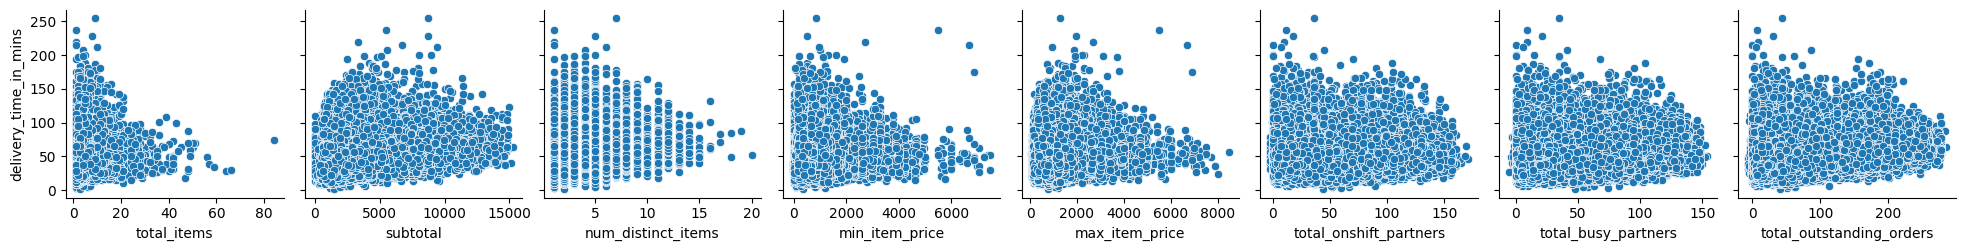

In [ ]:
cols = ['total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders']
sns.pairplot(data=df, x_vars=cols, y_vars='delivery_time_in_mins')
plt.show()

Above is the scatter plot of target feature with all the continuos features, we can see that not even a single feature has a linear relationship with the target variable which means that the numerical features also doesnt have much impact on the target feature.

As we know that our dataset and few categorical columns which we will have to ohe hot encode as these categorical features can be misinterpreted by our models as continuos features creating some kind of relationship with the target variable.
### **Feature Engineering:**

In [ ]:
# One Hot Encoding the categorical features
cat_cols = ['market_id', 'store_primary_category', 'order_protocol', 'hour_of_day', 'day_of_week']

ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(df[cat_cols])
feature_names = ohe.get_feature_names_out(cat_cols)

df_encoded = ohe.transform(df[cat_cols]).toarray()
df_encoded = pd.DataFrame(df_encoded, columns=feature_names).astype(int)
df_new = pd.concat([df.reset_index(drop=True), df_encoded], axis=1)

df_new.drop(cat_cols, axis=1, inplace=True)

### **Data Scaling:**

In [ ]:
# Before standardizing the data it is the best practice to divide the data into train and test.
Y = df_new['delivery_time_in_mins']
X = df_new.drop(['delivery_time_in_mins'], axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(X,Y,test_size=0.2,random_state=42)

In [ ]:
# Now scaling the continuos features of the data and not the one hot encoded ones.
for col in ['total_items', 'subtotal', 'num_distinct_items',
             'min_item_price', 'max_item_price', 'total_onshift_partners',
             'total_busy_partners', 'total_outstanding_orders']:
  scaler = StandardScaler()
  scaler.fit(xtrain[col].values.reshape(-1,1))
  xtrain[col] = scaler.transform(xtrain[col].values.reshape(-1,1))
  xtest[col] = scaler.transform(xtest[col].values.reshape(-1,1))

## **Model Building:**

In [ ]:
# At first we will creat a simple MLP network with no Droupout or Batchnormalization layers or any other hyperparameter.

model1 = Sequential([Dense(256,activation='relu'),
                    Dense(128,activation='relu'),
                    Dense(64,activation='relu'),
                    Dense(1,activation='linear')])

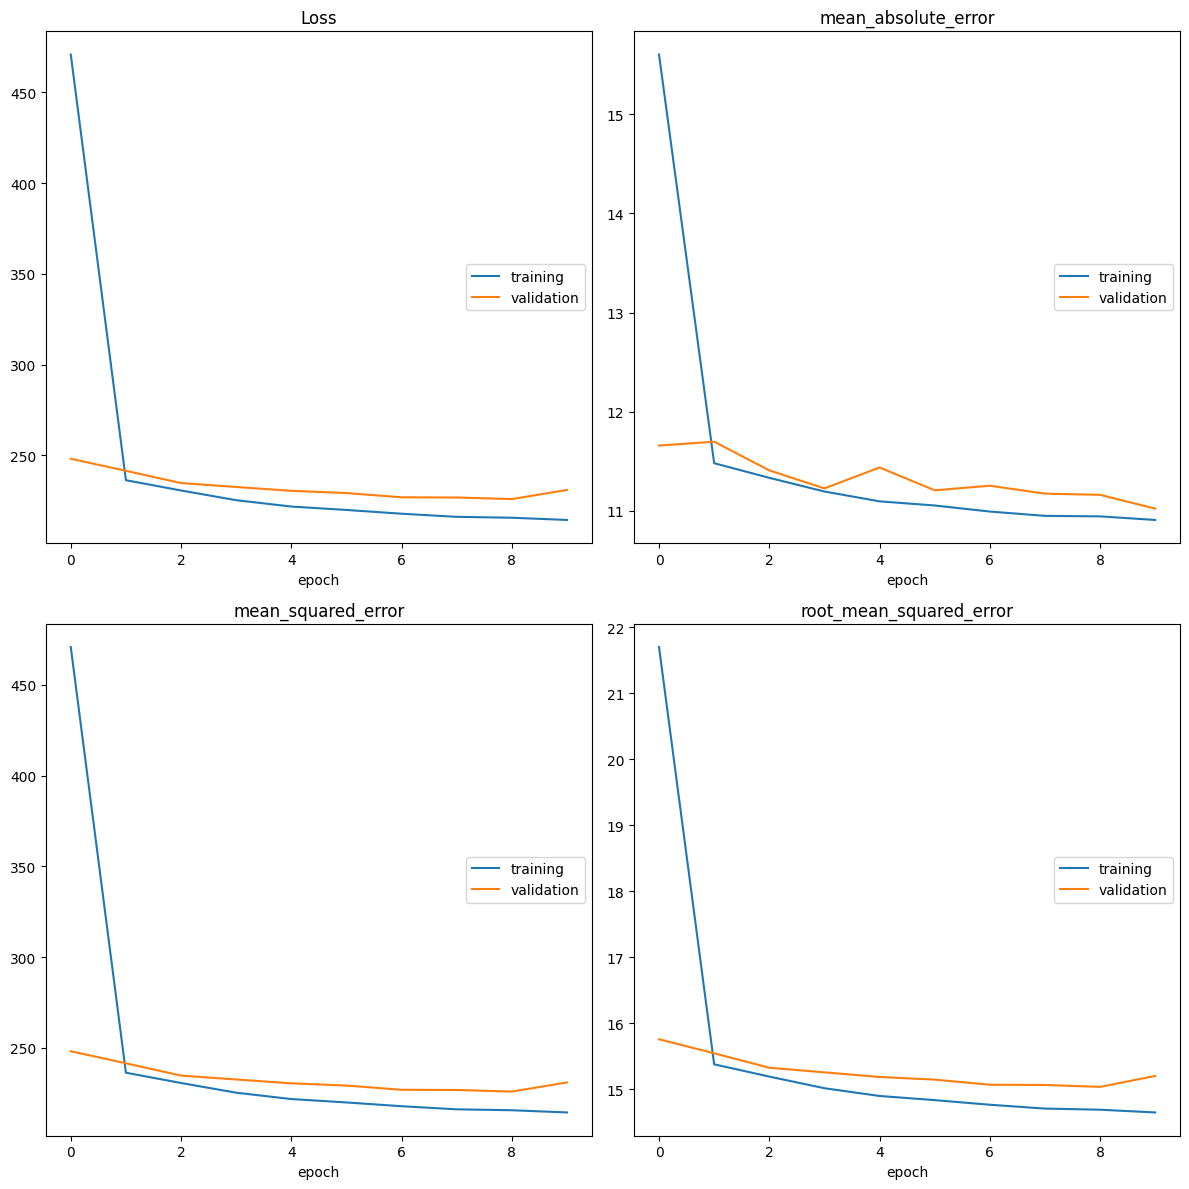

Loss
	training         	 (min:  214.491, max:  470.838, cur:  214.491)
	validation       	 (min:  225.998, max:  248.204, cur:  231.007)
mean_absolute_error
	training         	 (min:   10.907, max:   15.603, cur:   10.907)
	validation       	 (min:   11.021, max:   11.697, cur:   11.021)
mean_squared_error
	training         	 (min:  214.491, max:  470.838, cur:  214.491)
	validation       	 (min:  225.998, max:  248.204, cur:  231.007)
root_mean_squared_error
	training         	 (min:   14.646, max:   21.699, cur:   14.646)
	validation       	 (min:   15.033, max:   15.754, cur:   15.199)


In [ ]:
model1.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error','mean_absolute_error', tensorflow.keras.metrics.RootMeanSquaredError()])

history=model1.fit(xtrain, ytrain,
                  epochs=10,
                  batch_size=512,
                  verbose=0,
                  validation_split=0.2,
                  callbacks = [PlotLossesKeras()])

In [ ]:
model1.evaluate(xtest, ytest)

1211/1211 [==============================] - 8s 6ms/step - loss: 227.6332 - mean_squared_error: 227.6332 - mean_absolute_error: 10.9738 - root_mean_squared_error: 15.0875


[227.63320922851562,
 227.63320922851562,
 10.973767280578613,
 15.087518692016602]

**Below are the resultant metrics for baseline MLP model:**
*   For Training Set:
  *   Mean Squared Error (MSE) : 214.865
  *   Mean Absolute Error (MAE) : 10.919
  *   Root Mean Squared Error (RMSE) : 14.658

*   For Testing Set:
  *   Mean Squared Error (MSE) : 227.633
  *   Mean Absolute Error (MAE) : 10.973
  *   Root Mean Squared Error (RMSE) : 15.087

**Model Insight:**
The model appears to underfitting as the loss on training as well as testing data is quite high for a MLP model. Looks like the model is failing to learn the data patterns. To rectify this we can try to create a more dense MLP model.

In [ ]:
# Creating a more dense model so that our model can recognize the data patterns present in our dataset.
model2 = Sequential([Dense(1024,activation='relu'),
                    Dense(512,activation='relu'),
                    Dense(256,activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense(1,activation='linear')])

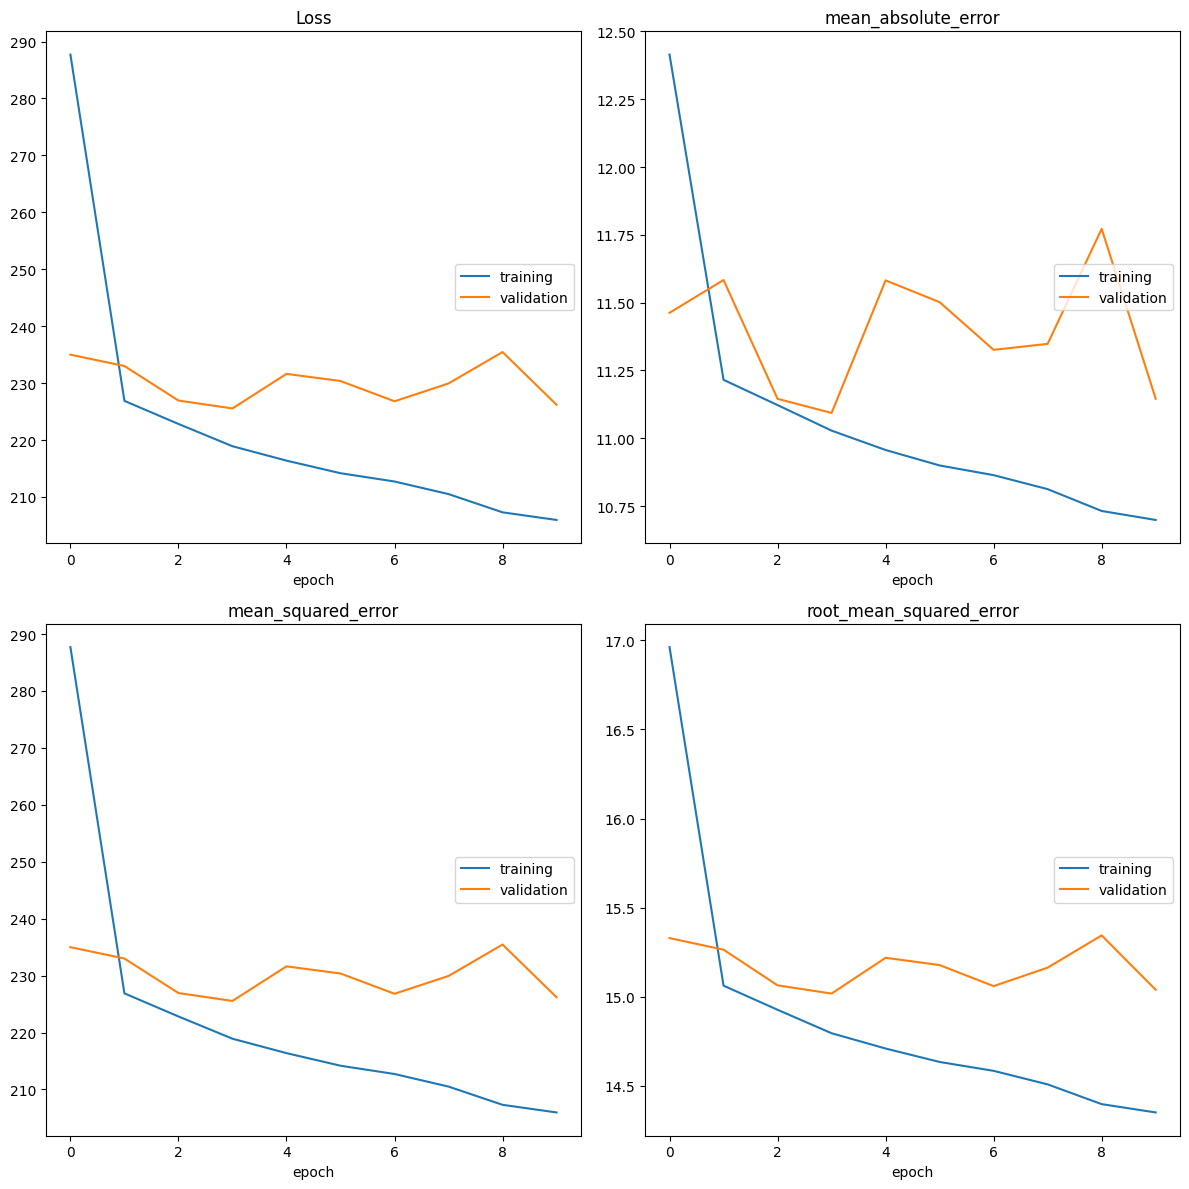

Loss
	training         	 (min:  205.963, max:  287.701, cur:  205.963)
	validation       	 (min:  225.551, max:  235.456, cur:  226.191)
mean_absolute_error
	training         	 (min:   10.699, max:   12.415, cur:   10.699)
	validation       	 (min:   11.093, max:   11.772, cur:   11.146)
mean_squared_error
	training         	 (min:  205.963, max:  287.701, cur:  205.963)
	validation       	 (min:  225.551, max:  235.456, cur:  226.191)
root_mean_squared_error
	training         	 (min:   14.351, max:   16.962, cur:   14.351)
	validation       	 (min:   15.018, max:   15.345, cur:   15.040)


In [ ]:
model2.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error','mean_absolute_error', tensorflow.keras.metrics.RootMeanSquaredError()])

history=model2.fit(xtrain, ytrain,
                  epochs=10,
                  batch_size=256,
                  verbose=0,
                  validation_split=0.2,
                  callbacks = [PlotLossesKeras()])

In [ ]:
model2.evaluate(xtest, ytest)

1211/1211 [==============================] - 11s 9ms/step - loss: 223.2137 - mean_squared_error: 223.2137 - mean_absolute_error: 11.1034 - root_mean_squared_error: 14.9403


[223.21372985839844, 223.21372985839844, 11.10336685180664, 14.940339088439941]

**Below are the resultant metrics for a Deep/Dense MLP model:**
*   For Training Set:
  *   Mean Squared Error (MSE) : 205.963
  *   Mean Absolute Error (MAE) : 10.699
  *   Root Mean Squared Error (RMSE) : 14.351

*   For Testing Set:
  *   Mean Squared Error (MSE) : 223.213
  *   Mean Absolute Error (MAE) : 11.103
  *   Root Mean Squared Error (RMSE) : 14.940

**Model Insight:**
After looking at the residual plots and metrics of training and testing set looks the model appears to overfitting as the loss on training data is reducing while the loss on testing data is increasing with each epoch after a certain point for this MLP model. To deal with this we will try to create a dense MLP model with L2-regularization, Batch Normalization and Dropout layer so that the model will generalize well for unseen data.

In [ ]:
# Creating a dense MLP model with a L2-regularization, batch normalization and dropout so that the model does not overfit on the training data.
# This model is same as the previous model only the extra thing present is regularization, dropout layer and batch normalization layer to optimize the model performance.
L2_reg = tensorflow.keras.regularizers.L2(l2=1e-6)

model3 = Sequential([Dense(1024,activation='relu', kernel_regularizer=L2_reg),
                    Dense(512,activation='relu', kernel_regularizer=L2_reg),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(256,activation='relu', kernel_regularizer=L2_reg),
                    Dense(128, activation='relu', kernel_regularizer=L2_reg),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(64, activation='relu', kernel_regularizer=L2_reg),
                    Dense(32, activation='relu', kernel_regularizer=L2_reg),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(16, activation='relu', kernel_regularizer=L2_reg),
                    Dense(1,activation='linear')])

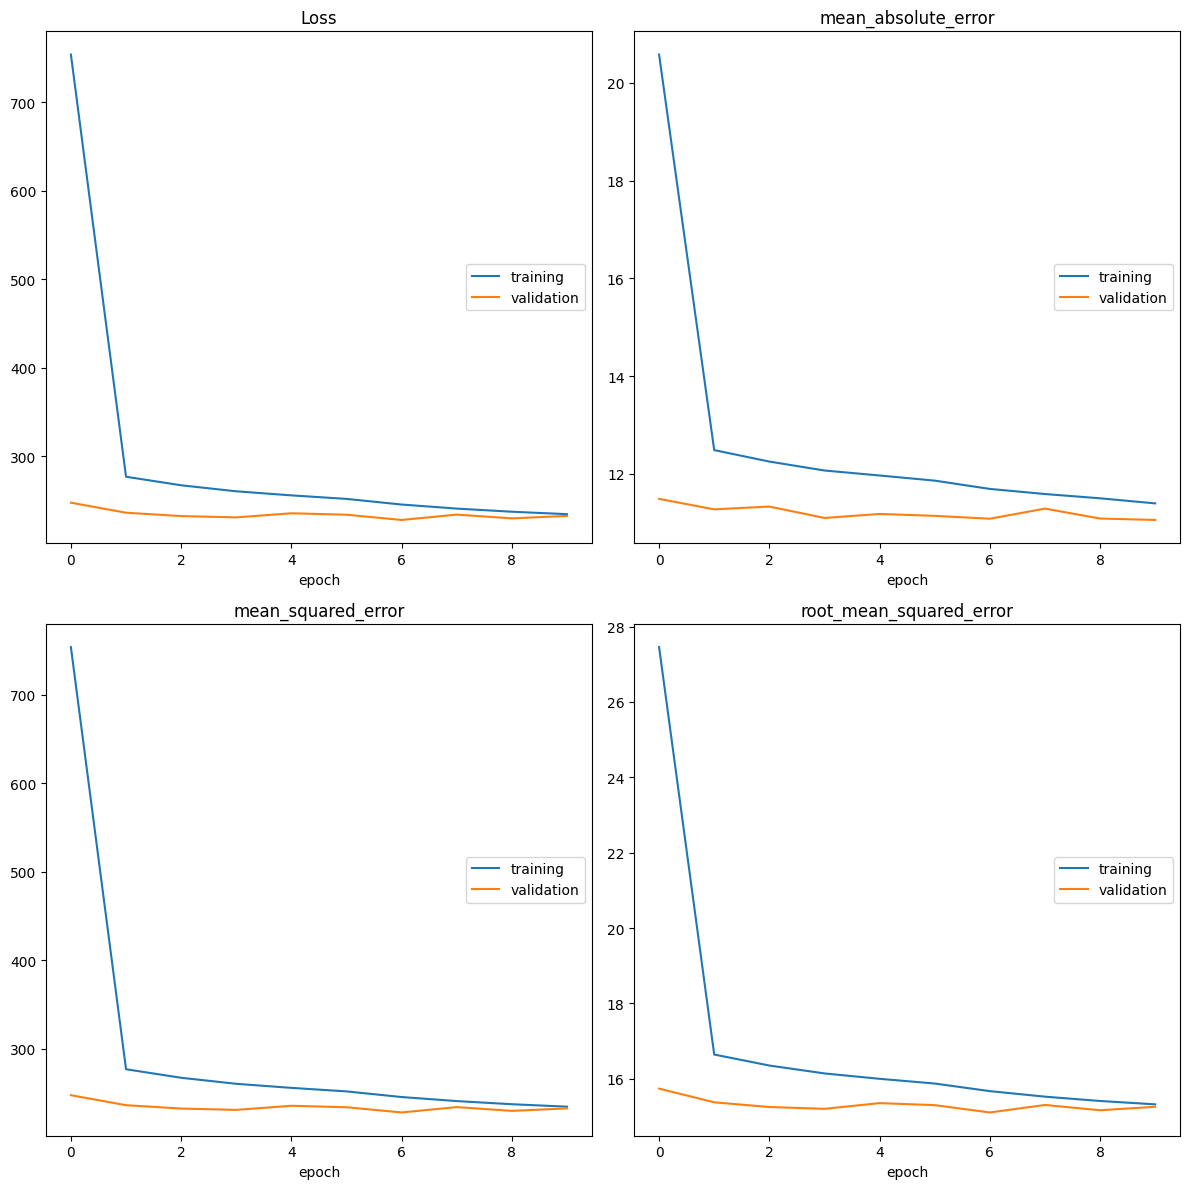

Loss
	training         	 (min:  234.696, max:  753.797, cur:  234.696)
	validation       	 (min:  228.151, max:  247.631, cur:  232.734)
mean_absolute_error
	training         	 (min:   11.396, max:   20.581, cur:   11.396)
	validation       	 (min:   11.057, max:   11.488, cur:   11.057)
mean_squared_error
	training         	 (min:  234.690, max:  753.796, cur:  234.690)
	validation       	 (min:  228.147, max:  247.629, cur:  232.728)
root_mean_squared_error
	training         	 (min:   15.320, max:   27.455, cur:   15.320)
	validation       	 (min:   15.105, max:   15.736, cur:   15.255)


In [ ]:
model3.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error','mean_absolute_error', tensorflow.keras.metrics.RootMeanSquaredError()])

history=model3.fit(xtrain, ytrain,
                  epochs=10,
                  batch_size=128,
                  verbose=0,
                  validation_split=0.2,
                  callbacks = [PlotLossesKeras()])

In [ ]:
model3.evaluate(xtest, ytest)

1211/1211 [==============================] - 12s 10ms/step - loss: 228.4389 - mean_squared_error: 228.4330 - mean_absolute_error: 10.9822 - root_mean_squared_error: 15.1140


[228.43894958496094, 228.4330291748047, 10.982172012329102, 15.114001274108887]

**Below are the resultant metrics for the final Deep/Dense MLP model:**
*   For Training Set:
  *   Mean Squared Error (MSE) : **234.696**
  *   Mean Absolute Error (MAE) : **11.396**
  *   Root Mean Squared Error (RMSE) : **15.320**

*   For Testing Set:
  *   Mean Squared Error (MSE) : **228.433**
  *   Mean Absolute Error (MAE) : **10.982**
  *   Root Mean Squared Error (RMSE) : **15.114**

**Model Insight:**
So far this is the best model created as it is not overfitting on the train data also the loss of training data and testing data is approximately same. This shows that the hyperparameter tuning is so far correct. But still the loss is not reduced below the 200, this gives the insight the model is slightly underfitting this may be happening due to the lack of data or less number of continuos features or impactful features which can describe the target variable through some relationship. So to cope up with this issue a larger dataset would help.

## **Key Observations:**


*   Upon comparing the performance of multiple Multi-Layer Perceptron (MLP) models, it is observed that all the models result in a similar Root Mean Square Error (RMSE) across the training, cross-validation, and testingstages. This consistent level of error, irrespective of the model or dataset partition used, signals an issue known as underfitting.

*   Underfitting occurs when a model is too simplistic or lacks the complexity to capture the underlying patterns in the data. In this scenario, all the MLPs are failing to provide accurate predictions for delivery time, indicating that the current set of features isinsufficient.

*   To address this issue, it is recommended to enrich the model with more features, or potentially investigate the creation of morecomplex, derived features from the existing data. By incorporating additional relevant features, the models would have more information to learn from, which could lead to improved accuracy in predicting delivery times.

*   To summarize, although the MLP models are different in nature and complexity, their similar performance in this case suggests that the key to improving delivery time predictions lies in enhancing the feature set rather than tweaking the models themselves.

# **Leading Questions:**

**1. Defining the problem statements and where can this and modifications of this be used?**

Ans: The problem statement is to predict the delivery time for orders placed through Porter, India's largest marketplace for intra-city logistics. This prediction model will be based on a range of factors including the type of order, the restaurant's location, the order protocol, and the numberof busy delivery partners. This predictive model, and variations of it, can be used in a wide range of logistics and delivery-related businesses like e-commerce, food delivery, and ride-hailing services where predicting delivery or arrival time is crucial for improving operational efficiency and customer satisfaction.

--------------------------------------------------------------------------------

**2. List 3 functions the pandas datetime provides with one line explanation.**

Ans:

1) pd.to_datetime(): Converts a string, integer, or float date to a datetime format, which was used to convert the 'created_at' and'actual_delivery_time' columns to datetime.

2) datetime.dt.hour: Extracts the hour from a datetime column, which can be used to get the hour of the day when the order was placed.

3) datetime.dt.dayofweek: Extracts the day of the week from a datetime column, which can be used to get the day of the week when the orderwas placed.

--------------------------------------------------------------------------------

**3. Short note on datetime, timedelta, time span (period)**

Ans:

1) datetime: In pandas, a datetime object represents a single moment in time. For example, the 'created_at' and 'actual_delivery_time' columnsin this dataset are datetime objects.

2) timedelta: A timedelta object represents a duration or difference between two dates or times. For example, the delivery time can be calculated as a timedelta by subtracting the order time from the delivery time.

3) time span (period): A time span or period represents a span of time (like a day, a month, or a year). In this project, the hour of the day andthe day of the week when the order was placed can be considered as time spans.

--------------------------------------------------------------------------------

**4. Why do we need to check for outliers in our data?**

Ans: We need to check for outliers because they can significantly skew our model's predictions. Outliers might be due to errors in data collection,and their presence can cause the model to learn based on these anomalies rather than the underlying data pattern. In the context of this project, an outlier might be an unusually long or short delivery time.

--------------------------------------------------------------------------------

**5. Name 3 outlier removal methods?**

Ans:

1) Z-Score: This method calculates the Z-score of every data point, which measures how many standard deviations a point is from the mean.Data points with a Z-score greater than a certain threshold (commonly 3) are considered outliers.

2) Interquartile Range (IQR): This method defines outliers as points that fall outside of the IQR. The IQR is the range between the first quartile(25th percentile) and the third quartile (75th percentile).

3) Boxplot Method: This is a graphical method based on quartiles. In a boxplot, an outlier is any value that falls outside the whiskers, which typically represent 1.5 times the IQR above the third quartile or below the first quartile.

--------------------------------------------------------------------------------

**6. What classical machine learning methods can we use for this problem?**

Ans:

1) Linear Regression: This is a simple and widely used regression method that assumes a linear relationship between the features and thetarget variable.

2) Support Vector Regression: This is a version of Support Vector Machines (SVM) that can be used for regression problems.

3) Gradient Boosting: This is an ensemble method that combines multiple weak learners into a strong learner. It builds trees one - at a time,and each new tree helps to correct errors made by the previously trained tree.

--------------------------------------------------------------------------------

**7. Why is scaling required for neural networks?**

Ans: Scaling is required for neural networks because they are sensitive to the scale of the input features. Different scales in the input data can lead to slow convergence or the model being stuck in suboptimal solutions during training. Scaling ensures that all features have a similar scale, which makes the training process more stable and efficient. In the context of this project, scaling is used before feeding the data to the neural network model.

--------------------------------------------------------------------------------

**8. Briefly explain your choice of optimizer.**

Ans: The 'Adam' optimizer was used in this scenario. Adam, short for Adaptive Moment Estimation, is a popular choice for training neural networks due to its efficiency and effectiveness. It combines the benefits of two other extensions of stochastic gradient descent: AdaGrad(Momentum) and RMSProp. Specifically, Adam computes adaptive learning rates for different parameters, which makes it suitable fordealing with problems involving large data or parameters.

--------------------------------------------------------------------------------

**9. Which activation function did you use and why?**

Ans: The 'ReLU' (Rectified Linear Unit) activation function was used in the hidden layers of the neural network. ReLU is a commonly used activation function in deep learning models because it introduces non-linearity without being computationally expensive. It is represented mathematically as f(x) = max(0, x). In practice, applying ReLU means that if an input is positive, it is kept as is, while if it's negative, it's changed to 0. This allows the model to learn complex patterns and helps in mitigating the vanishing gradient problem.
In the output layer, no activation function was specified, which means a linear activation function is used by default. This is appropriatefor regression problems, where the output can be any real number.

--------------------------------------------------------------------------------

**10. Why does a neural network perform well on a large dataset?**

Ans: Neural networks perform well on large datasets because they have the capacity to model complex patterns and relationships in the data.With a large number of parameters, they can capture intricate structures in high-dimensional data. However, this also means they need a lot of data to estimate these parameters effectively and avoid overfitting. Therefore, the larger the dataset, the better the neural network can learn and generalize from it. In the context of this project, the large number of deliveries in the dataset allows the neural network to learn a wide variety of patterns in delivery times.
Additionally, the use of Dropout and BatchNormalization layers in the network architecture helps improve the model's performance.Dropout layers help prevent overfitting by randomly setting a fraction of input units to 0 at each update during training, which helps to introduce randomness and robustness into the model. BatchNormalization layers normalize the activations of the previous layer at each batch improving stability and accelerating the learning process. The L2-Regularization added to the Dense layers also helps prevent the model from overfitting as it penalizes the loss.

--------------------------------------------------------------------------------